**VGG16 Model**

In [20]:
import os
import cv2
import keras 
import numpy as np
import pandas as pd
from PIL import Image


from keras.layers import * 
from tensorflow.keras import layers
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout

from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

**Connecting to Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Splitting**

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/IMG_CLASSES', output="/content/drive/MyDrive/CLASSES_5", seed=1337, ratio=(.7,0.3))

**Loading the Dataset**

In [3]:
train_path="/content/drive/MyDrive/CLASSES_5/train"
test_path="/content/drive/MyDrive/CLASSES_5/val"

**Data Agumentaion**

In [4]:
datagen_train = ImageDataGenerator(rotation_range=60, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input) # VGG16 preprocessing

datagen_test= ImageDataGenerator(preprocessing_function=preprocess_input)

Dataset_train = datagen_train.flow_from_directory(train_path, target_size=(224, 224), batch_size=64, class_mode='categorical', shuffle=True , seed = 42)

Dataset_test = datagen_test.flow_from_directory(test_path, target_size=(224, 224),  batch_size=64,class_mode='categorical',shuffle=True , seed = 42)

Found 8051 images belonging to 5 classes.
Found 3455 images belonging to 5 classes.


In [5]:
Dataset_train.class_indices


{'1. Eczema 1677': 0,
 '2. Melanoma 15.75k': 1,
 '3. Atopic Dermatitis - 1.25k': 2,
 '4. Basal Cell Carcinoma (BCC) 3323': 3,
 '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 4}

**Load in Pretrained VGG16 Model**

In [6]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

print(len(base_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


**Define the Model**

In [7]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(4000, activation='relu')(x)
x = layers.Dense(2000, activation='relu')(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)

# Add a final softmax layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)



In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['Accuracy'])

In [10]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [11]:
history = model.fit(Dataset_train ,
                              batch_size=64,
                              epochs = 30, 
                              validation_data = (Dataset_test),
                              steps_per_epoch= Dataset_train.samples // 64,
                              validation_steps=Dataset_test.samples // 64,
                              verbose = 1,
                              callbacks=[early_stop]
                        )

Epoch 1/30
125/125 [==============================] - 242s 2s/step - loss: 27.9587 - Accuracy: 0.5923 - val_loss: 1.0901 - val_Accuracy: 0.6798
Epoch 2/30
125/125 [==============================] - 219s 2s/step - loss: 1.1210 - Accuracy: 0.6930 - val_loss: 1.1496 - val_Accuracy: 0.7002
Epoch 3/30
125/125 [==============================] - 211s 2s/step - loss: 0.9231 - Accuracy: 0.6989 - val_loss: 2.4565 - val_Accuracy: 0.6642
Epoch 4/30
125/125 [==============================] - 210s 2s/step - loss: 0.8204 - Accuracy: 0.7152 - val_loss: 1.0872 - val_Accuracy: 0.7341
Epoch 5/30
125/125 [==============================] - 209s 2s/step - loss: 0.6765 - Accuracy: 0.7262 - val_loss: 0.6209 - val_Accuracy: 0.7571
Epoch 6/30
125/125 [==============================] - 211s 2s/step - loss: 0.5851 - Accuracy: 0.7493 - val_loss: 0.5925 - val_Accuracy: 0.7621
Epoch 7/30
125/125 [==============================] - 208s 2s/step - loss: 0.5765 - Accuracy: 0.7550 - val_loss: 0.5512 - val_Accuracy: 0.801

In [24]:
history.history.keys()

dict_keys(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'])

Text(0.5, 0, 'epoch')

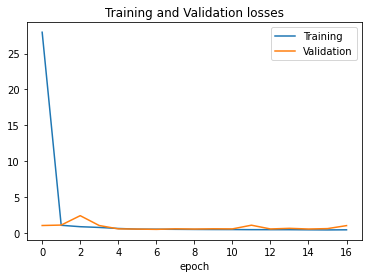

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

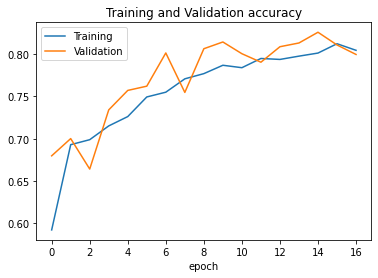

In [28]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')

In [29]:
test_loss, test_acc = model.evaluate(Dataset_test)
print('test loss :{}   test accuracy :{}'.format(test_loss,test_acc))

54/54 [==============================] - 41s 762ms/step - loss: 0.5502 - Accuracy: 0.8012
test loss :0.5502020716667175   test accuracy :0.8011577129364014
